In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_folder_path = '/content/drive/MyDrive/model'

# TD

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 740.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model_TD = YOLO(model_folder_path + '/1.pt')

# split

## function

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.ops as ops
import math
import cv2
import ast


import glob
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets

In [ ]:
SHAPE = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set device to gpu or cpu
device

device(type='cpu')

In [ ]:
class Resnet_FPN_split(nn.Module):
    def __init__(self,out_channels = 128):
        super(Resnet_FPN_split, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.to(device)
        self.layer_1 = nn.Sequential(*list(self.resnet.children())[:4])
        self.layer_2 = self.resnet.layer2
        self.layer_3 = self.resnet.layer3
        self.layer_4 = self.resnet.layer4

        self.lateral4 = nn.Conv2d(512, out_channels, kernel_size=1, stride=1, padding=0)
        self.lateral3 = nn.Conv2d(256, out_channels, kernel_size=1, stride=1, padding=0)
        self.lateral2 = nn.Conv2d(128, out_channels, kernel_size=1, stride=1, padding=0)
        self.lateral1 = nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0)

        self.output4 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.output3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.output2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.output1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        if (torch.isnan(x).any()):
            print("error at Resnet_FPN")
        c1 = self.layer_1(x)
        if (torch.any(torch.isnan(c1))):
            print('error resnet ')
        c2 = self.layer_2(c1)
        c3 = self.layer_3(c2)
        c4 = self.layer_4(c3)

        p4 = self.lateral4(c4)
        p3 = self.lateral3(c3) + F.interpolate(p4, scale_factor=2, mode='nearest')
        p2 = self.lateral2(c2) + F.interpolate(p3, scale_factor=2, mode='nearest')
        p1 = self.lateral1(c1) + F.interpolate(p2, scale_factor=2, mode='nearest')

        p4 = self.output4(p4)
        p3 = self.output3(p3)
        p2 = self.output2(p2)
        p1 = self.output1(p1)

        return p1, p2, p3, p4

In [ ]:
class transferlayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(transferlayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class mess_passing_H(nn.Module):
    def __init__(self, in_channels = 32, out_channels= 32):
        super(mess_passing_H, self).__init__()
        self.t2d_layers = nn.Conv2d(in_channels, out_channels, kernel_size=[1,9], stride=(1,1), padding=(0,4))
        self.d2t_layers = nn.Conv2d(in_channels, out_channels, kernel_size=[1,9], stride=(1,1), padding=(0,4))
        self.relu = nn.ReLU()
    def forward(self, x):
        nB, c, h, w = x.shape
        feature_list_old = []
        feature_list_new = []
        for cnt in range(h):
            feature_list_old.append(x[:,:,cnt,:].unsqueeze(dim = 2))
        feature_list_new.append(x[:,:,0,:].unsqueeze(dim = 2))
        feature = self.t2d_layers(feature_list_old[0])
        feature = self.relu(feature) + feature_list_old[1]
        feature_list_new.append(feature)
        for cnt in range(2,h):
            feature =  self.t2d_layers(feature_list_new[cnt-1])
            feature = self.relu(feature) + feature_list_old[cnt]
            feature_list_new.append(feature)
        feature_list_new.append(feature)
        feature_list_old = feature_list_new
        feature_list_new = []
        length = h - 1
        feature_list_new.append(feature_list_old[length])
        feature = self.d2t_layers(feature_list_old[length])
        feature = self.relu(feature) + feature_list_old[length - 1]
        feature_list_new.append(feature)
        for cnt in range(2, h):
            feature = self.d2t_layers(feature_list_new[cnt - 1])
            feature = self.relu(feature) + feature_list_old[length - cnt]
            feature_list_new.append(feature)
        feature_list_new.reverse()
        processed_feature = torch.stack(feature_list_new,dim = 2)
        processed_feature = processed_feature.squeeze(dim = 3 )
        return processed_feature

In [ ]:
class mess_passing_W(nn.Module): # L -> R
    def __init__(self, in_channels = 32, out_channels= 32):
        super(mess_passing_W, self).__init__()
        self.l2r_layers = nn.Conv2d(in_channels, out_channels, kernel_size=[9,1], stride=(1,1), padding=(4,0))
        self.r2l_layers = nn.Conv2d(in_channels, out_channels, kernel_size=[9,1], stride=(1,1), padding=(4,0))
        self.relu = nn.ReLU()
    def forward(self, x):
        nB, c, h, w = x.shape
        feature_list_old = []
        feature_list_new = []
        for cnt in range(w):
            feature_list_old.append(x[:, :, : , cnt].unsqueeze(dim = 3))
        feature_list_new.append(x[:, :, :, 0].unsqueeze(dim = 3))
        feature = self.l2r_layers(feature_list_old[0])
        feature = self.relu(feature) + feature_list_old[1]
        feature_list_new.append(feature)
        for cnt in range(2, w):
            feature = self.l2r_layers(feature_list_new[cnt - 1])
            feature = self.relu(feature) + feature_list_old[cnt]
            feature_list_new.append(feature)
        feature_list_old = feature_list_new
        feature_list_new = []
        length = w - 1
        feature_list_new.append(feature_list_old[length])
        feature = self.r2l_layers(feature_list_old[length])
        feature = self.relu(feature) + feature_list_old[length - 1]
        feature_list_new.append(feature)
        for cnt in range(2, w):
            feature = self.r2l_layers(feature_list_new[cnt - 1])
            feature = self.relu(feature) + feature_list_old[length - cnt]
            feature_list_new.append(feature)
        feature_list_new.reverse()
        processed_feature = torch.stack(feature_list_new, dim=3)
        processed_feature = torch.squeeze(processed_feature, axis=4)
        return processed_feature

In [ ]:
class sun_branch_1(nn.Module):
    def __init__(self, size_):
        super(sun_branch_1, self).__init__()
        self.size_ = size_
        self.Max = nn.MaxPool2d(kernel_size=size_, stride=size_ , padding= (0,0))
        self.Conv = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding= 1)
        self.relu = nn.ReLU()
    def forward(self, x , input_channel):
        x = x.clone()
        x = self.Max(x)
        x = self.Conv(x)
        x = self.relu(x)
        return x

In [ ]:
class sun_branch_2(nn.Module):
    def __init__(self, size_):
        super(sun_branch_2, self).__init__()
        self.size_ = size_
        self.Max = nn.MaxPool2d(kernel_size=size_, stride=size_ , padding= (0,0))
        self.Conv = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding= 1)
        self.relu = nn.ReLU()
    def forward(self, x , input_channel):
        x = x.clone()
        x = self.Max(x)
        x = self.Conv(x)
        x = self.relu(x)
        return x

In [ ]:
class sun_branch_3(nn.Module):
    def __init__(self, size_):
        super(sun_branch_3, self).__init__()
        self.size_ = size_
        self.Max = nn.MaxPool2d(kernel_size=size_, stride=size_ , padding= (0,0))
        self.Conv = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding= 1)
        self.relu = nn.ReLU()
    def forward(self, x , input_channel):
        x = x.clone()
        x = self.Max(x)
        x = self.Conv(x)
        x = self.relu(x)
        return x

In [ ]:
class updasample_combines(nn.Module):
    def __init__(self ):
        super(updasample_combines, self).__init__()
        self.conv = nn.Conv2d(32, 256, kernel_size=3, stride=1, padding= 'same')
        self.bn = nn.BatchNorm2d(256)
        self.relu = nn.ReLU()
    def forward(self, x_tensor):
        x = F.interpolate(x_tensor, size =(SHAPE,SHAPE), mode='bilinear', align_corners=False)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
class predict_row(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(predict_row, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        row_ = self.conv(x)
        final_row = self.sigmoid(row_)
        return final_row

# %%
class predict_col(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(predict_col, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        col_ = self.conv(x)
        final_col = self.sigmoid(col_)
        return final_col

In [ ]:
class model_split(nn.Module):
    def __init__(self):
        super(model_split, self).__init__()  # 128 -> 256
        self.backbone = Resnet_FPN_split()
        self.mess_passing_H = mess_passing_H()
        self.mess_passing_W = mess_passing_W()
        self.predict_row = predict_row(256, 1)
        self.predict_col = predict_col(256, 1)
        self.sun_branch_W_1 = sun_branch_1(size_=(1,2))
        self.sun_branch_W_2 = sun_branch_2(size_=(1,2))
        self.sun_branch_W_3 = sun_branch_3(size_=(1,2))

        self.sun_branch_H_1 = sun_branch_1(size_=(2,1))
        self.sun_branch_H_2 = sun_branch_2(size_=(2,1))
        self.sun_branch_H_3 = sun_branch_3(size_=(2,1))

        self.transfer_layer = transferlayer(128, 64)  # 256 -> 16
        self.updasample_combines_H = updasample_combines()
        self.updasample_combines_W = updasample_combines()  # 256 * 256
    def forward(self, image):
        c2, c3 , c4, c5 = self.backbone(image)
        fm = self.transfer_layer(c2)
        x_H = fm
        x_W = fm
        # for _ in range(3):
        x_H= self.sun_branch_H_1(x_H, x_H.shape[1])
        x_H= self.sun_branch_H_2(x_H, x_H.shape[1])
        x_H= self.sun_branch_H_3(x_H, x_H.shape[1])

        x_W = self.sun_branch_W_1(x_W, x_W.shape[1])
        x_W = self.sun_branch_W_2(x_W, x_W.shape[1])
        x_W = self.sun_branch_W_3(x_W, x_W.shape[1])
        # print(f'x_W : {x_W.shape}')
        col_feature = self.mess_passing_H(x_H)
        col_feature = self.updasample_combines_H(col_feature)  # 256 * 256

        row_feature = self.mess_passing_W(x_W)
        row_feature = self.updasample_combines_W(row_feature)  # 256 * 256
        # print(f'row_feature :{row_feature.shape}, col_feature:{col_feature.shape}')
        final_row = self.predict_row(row_feature)
        final_col = self.predict_col(col_feature)
        return final_row, final_col

In [ ]:
def get_heatmap_split(tensor_input , show = False):
    pred = tensor_input[0]
    pred = pred.permute(1,2,0)
    pred = pred.cpu()
    pred = pred.detach().numpy()
    if show == True:
      plt.imshow(pred)
    return pred

In [ ]:
def contour_dis(contour_1, contour_2):
    min_dis = 99999
    for point1 in contour_1:
        for point2 in contour_2:
            dis = np.linalg.norm(point1[0] - point2[0])
            if dis < min_dis:
                min_dis = dis
    return min_dis

def merge_countour(contour_1, contour_2):
    merge_c = np.vstack((contour_1, contour_2))
    merge_c = cv2.convexHull(merge_c)
    return merge_c


In [ ]:
def get_col_pred_line(img_col_pred):
  test_image = img_col_pred[0]
  test_image =   test_image.permute(1,2,0)
  test_image = test_image.cpu()
  test_image_np = test_image.detach().numpy()
  col_img_pred = test_image_np.copy()
  col_img_pred = np.squeeze(col_img_pred, axis= 2)
  reversed_binary_img = 1 - col_img_pred
  col_mean = np.mean(col_img_pred , axis = 0)
  mask_1 = col_mean> threshold
  mask_0 = col_mean <= threshold
  col_mean[mask_1] = 0
  col_mean[mask_0] = 1
  image_finale_col_pred = np.tile(col_mean, (512, 1))
  contours, hierarchy = cv2.findContours(image_finale_col_pred.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  final_countours = []
  used = set()
  for i, contour_1 in enumerate(contours):
    if i in used:
      continue
    for j, contour_2 in enumerate(contours):
      if i!= j and j not in used:
        dis = contour_dis(contour_1, contour_2)
        if dis < threshold_contour_col:
            contour_1 = merge_countour(contour_1, contour_2)
            used.add(j)
    final_countours.append(contour_1)
    used.add(i)
  polynomial_fits = []
  for i, contour in enumerate(final_countours):
    x = contour[:, 0, 1]
    y = contour[:, 0, 0]
    try:
      polynomial_fit = np.polyfit(x, y, 0)
      polynomial_fits.append(polynomial_fit)
    except:
        pass
  final_list = []
  for line in polynomial_fits:
    line_int = int(line[0])
    final_list.append(line_int)
  return final_list

In [ ]:
def get_row_pred_line(img_row_pred):
  test_image = img_row_pred[0]
  # print(test_image.shape)
  test_image =   test_image.permute(1,2,0)
  test_image = test_image.cpu()
  # test_image_np = np.array(test_image)
  test_image_np = test_image.detach().numpy()
  row_img_pred = test_image_np.copy()
  row_img_pred = np.squeeze(row_img_pred, axis= 2)
  reversed_binary_img = 1 - row_img_pred
  row_mean = np.mean(row_img_pred , axis = 1)
  mask_1 = row_mean> threshold
  mask_0 = row_mean <= threshold
  row_mean[mask_1] = 0
  row_mean[mask_0] = 1
  row_mean_reshape = row_mean.reshape(512,1)
  # print(row_mean)
  image_finale_row_pred = np.tile(row_mean_reshape, (1, 512))
  contours, hierarchy = cv2.findContours(image_finale_row_pred.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  final_countours = []
  used = set()
  for i, contour_1 in enumerate(contours):
    if i in used:
      continue
    for j, contour_2 in enumerate(contours):
      if i!= j and j not in used:
        dis = contour_dis(contour_1, contour_2)
        if dis < threshold_contour_row:
            contour_1 = merge_countour(contour_1, contour_2)
            used.add(j)
    final_countours.append(contour_1)
    used.add(i)

  polynomial_fits = []
  for i, contour in enumerate(final_countours):
    x = contour[:, 0, 1]
    y = contour[:, 0, 0]
    try:
      polynomial_fit = np.polyfit(y, x, 0)
      polynomial_fits.append(polynomial_fit)
    except:
      pass
  final_list = []
  for line in polynomial_fits:
    line_int = int(line[0])
    final_list.append(line_int)
  return final_list

In [ ]:
def show_line_pred(row_list, col_list, image_np):
  image_input = cv2.resize(image_np, (512,512))
  for line in row_list:
    # print(line)
    y_coord = line
    start_point = (0, y_coord)
    end_point = (512, y_coord)
    cv2.line(image_input, start_point, end_point, (255,0,0),1)
    # print(line[0])
  for line in col_list:
    # print(line)
    x_coord = line
    start_point = (x_coord, 0)
    end_point = (x_coord, 512)
    cv2.line(image_input, start_point, end_point, (255,0,0),1)
  plt.imshow(image_input)
  plt.show()

In [ ]:
def get_pred_bbox_list(row_list_final, col_list_final):
    row_bbox_list = []
    for index in range(len(row_list_final) - 1):
        row_bbox_list.append([row_list_final[index], row_list_final[index + 1]])
    col_bbox_list = []
    for index in range(len(col_list_final) - 1):
        col_bbox_list.append([col_list_final[index], col_list_final[index + 1]])
    # print(row_bbox_list)
    # print(col_bbox_list)
    cell_bbox_list = []
    for row_idx , row_bbox in enumerate(row_bbox_list):
        for col_idx, col_bbox in enumerate(col_bbox_list):
            x1 = col_bbox[0]
            y1 = row_bbox[0]
            x2 = col_bbox[1]
            y2 = row_bbox[1]
            updated_bbox = [row_idx, col_idx, x1, y1, x2, y2]
            cell_bbox_list.append(updated_bbox)
    return cell_bbox_list

## using split

In [ ]:
split_task = model_split()
split_task.to('cpu')
weights = torch.load( model_folder_path + "/split_model_fintab_80k_20.pth", map_location='cpu')
split_task.load_state_dict(weights)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-22-3ca3d09bb5fb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

<All keys matched successfully>

# Merge

## function

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.ops as ops
import math
import cv2
import ast
from tqdm import  tqdm

import glob
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
class Resnet_FPN_merge(nn.Module):
    def __init__(self,out_channels = 256):
        super(Resnet_FPN_merge, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.to(device)
        self.layer_1 = nn.Sequential(*list(self.resnet.children())[:4])
        self.layer_2 = self.resnet.layer2
        self.layer_3 = self.resnet.layer3
        self.layer_4 = self.resnet.layer4

        self.lateral4 = nn.Conv2d(512, out_channels, kernel_size=1, stride=1, padding=0)
        self.lateral3 = nn.Conv2d(256, out_channels, kernel_size=1, stride=1, padding=0)
        self.lateral2 = nn.Conv2d(128, out_channels, kernel_size=1, stride=1, padding=0)
        self.lateral1 = nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0)

        self.output4 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.output3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.output2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.output1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        if (torch.isnan(x).any()):
            print("error at Resnet_FPN")
        c1 = self.layer_1(x)
        if (torch.any(torch.isnan(c1))):
            print('error resnet ')
        c2 = self.layer_2(c1)
        c3 = self.layer_3(c2)
        c4 = self.layer_4(c3)

        p4 = self.lateral4(c4)
        p3 = self.lateral3(c3) + F.interpolate(p4, scale_factor=2, mode='nearest')
        p2 = self.lateral2(c2) + F.interpolate(p3, scale_factor=2, mode='nearest')
        p1 = self.lateral1(c1) + F.interpolate(p2, scale_factor=2, mode='nearest')

        p4 = self.output4(p4)
        p3 = self.output3(p3)
        p2 = self.output2(p2)
        p1 = self.output1(p1)

        return p1, p2, p3, p4

In [ ]:
def convert_rois_to_boxes(rois):
    MxN = (torch.max(rois[:,0])+1)*(torch.max(rois[:,1])+1).item()
    MxN = int(MxN)
    batch_index = torch.zeros(MxN)
    x1 = rois[:,2]
    y1 = rois[:,3]
    x2 = rois[:,4]
    y2 = rois[:,5]

    boxes = torch.stack([batch_index,x1,y1,x2,y2],dim=1)
    return boxes

In [ ]:
def roi_align(feature_map, rois, output_size = (7,7)):
    return ops.roi_align(feature_map, rois, output_size , spatial_scale=1/4)

In [ ]:
class convert_rois_to_box(nn.Module):
    def __init__(self):
        super(convert_rois_to_box, self).__init__()
        # pass
    def forward(self, rois):
        MxN = (torch.max(rois[:,0])+1)*(torch.max(rois[:,1])+1).item()
        MxN = int(MxN)
        batch_index = torch.zeros(MxN)

        batch_index = batch_index.to(device)
        x1 = rois[:,2]
        y1 = rois[:,3]
        x2 = rois[:,4]
        y2 = rois[:,5]

        boxes = torch.stack([batch_index,x1,y1,x2,y2],dim=1)
        return boxes

In [ ]:
class position_embedding(nn.Module):
    def __init__(self, num_paches = 100, projection_dims = 256):
        super(position_embedding, self).__init__()
        self.x_position_embeddings = nn.Embedding(num_paches, projection_dims)
        nn.init.constant_(self.x_position_embeddings.weight, 0.)
        self.y_position_embeddings = nn.Embedding(num_paches, projection_dims)
        nn.init.constant_(self.y_position_embeddings.weight, 0.)
    def forward(self, rois):
        x = torch.max(rois[:,1])
        y = torch.max(rois[:,0])

        x = x.to(torch.int32)
        y = y.to(torch.int32)
        x_1 = x+1
        y_1 = y+1

        col = torch.arange(x+1)
        col = col.to(device)
        row = torch.arange(y+1)
        row = row.to(device)

        x_pos = col.repeat(y_1)
        y_pos = row.repeat_interleave(x_1)

        x_embed = self.x_position_embeddings(x_pos)
        y_embed = self.y_position_embeddings(y_pos)

        return x_embed, y_embed

In [ ]:
class predict_head_row(nn.Module):
    def __init__(self,hidden_dim = 512):
        super(predict_head_row, self).__init__()
        self.hidden_dim = hidden_dim
        self.ff1 = nn.Linear(in_features=512, out_features=512)
        self.ff2 = nn.Linear(in_features=512, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.ff1(x)
        x = self.relu(x)
        x= self.ff2(x)
        # x = self.relu(x)
        x = self.sigmoid(x)
        return x
class predict_head_col(nn.Module):
    def __init__(self,hidden_dim = 512):
        super(predict_head_col, self).__init__()
        self.hidden_dim = hidden_dim
        self.ff1 = nn.Linear(in_features=512, out_features=512)
        self.ff2 = nn.Linear(in_features=512, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.ff1(x)
        x = self.relu(x)
        x= self.ff2(x)
        # x = self.relu(x)
        x = self.sigmoid(x)
        return x

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim = 512, num_layers = 3, num_heads = 8, ff_dim = 512):
        super(TransformerEncoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.input_dim = input_dim

    def forward(self, src):
        src = src * torch.sqrt(torch.tensor(self.input_dim, dtype=torch.float32))
        output = self.transformer_encoder(src)
        return output

In [ ]:
class Model_merge(nn.Module):
    def __init__(self, num_layers = 3 ):
        super(Model_merge, self).__init__()
        self.pos_embedding = position_embedding()
        self.convert_rois_to_box = convert_rois_to_box()
        self.encoder = TransformerEncoder()
        self.backbone = Resnet_FPN_merge()

        # self.merge_head = merge_head()
        self.row_head = predict_head_row()
        self.col_head = predict_head_col()
        self.middle = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1)
        self.flatten_fm = nn.Linear(in_features= 6272, out_features= 512)
    def forward(self, x , rois):
        if (torch.isnan(x).any()):
            print("error fw model ")
        rois_1 = torch.tensor(rois[0].cpu().numpy())
        rois_new = self.convert_rois_to_box(rois_1)
        x_embed, y_embed = self.pos_embedding(rois[0])
        if (torch.any(torch.isnan(x_embed))):
            print('pos error')
        elif  (torch.any(torch.isnan(y_embed))):
            print('pos error')
        pos_  = torch.cat((x_embed, y_embed), dim=-1) # (1, MxN, 512)
        p1, p2, p3, p4 = self.backbone(x) # p1: (1, 256, 128, 128)
        if  (torch.any(torch.isnan(p1))):
            print('feature error')
        feature_map = self.middle(p1) #  (1, 256, 128, 128)
        # print(f'feature_map :{feature_map.shape}')
        crops = roi_align(feature_map, rois_new) # (MxN, 128, 7, 7)
        if  (torch.any(torch.isnan(crops))):
            print(' roi align error ')
        embedded_patches = crops.reshape(-1, 128*7*7) # (MxN, 6272)
        encoded_patches = self.flatten_fm(embedded_patches)# (MxN, 512)
        encoded_patches = torch.unsqueeze(encoded_patches, dim=0) # (1, MxN, 512)
        encode = pos_ + encoded_patches # (1, MxN , 512)
        # encode = encoded_patches

        x = self.encoder(encode) # (1, MxN, 512)
        if  (torch.any(torch.isnan(x))):
            print(' encoder error ')
        row_logits = self.row_head(x)
        col_logits = self.col_head(x)
        col_logits = col_logits.view(-1)
        row_logits = row_logits.view(-1)
        return row_logits , col_logits

In [ ]:
def get_final_pred_merge(row_pred, col_pred, num_row, num_col):
    pred_col = col_pred.cpu()
    mask_1 = pred_col > 0.9
    mask_0 = pred_col <=0.9
    final_pred_col = np.zeros(shape = np.shape(pred_col) , dtype= int)
    final_pred_col[np.where(mask_1 == True)] = 1
    final_pred_col = np.reshape(final_pred_col, (num_row + 1, num_col + 1))

    pred_row = row_pred.cpu()
    mask_1 = pred_row > 0.9
    mask_0 = pred_row <=0.9
    final_pred_row = np.zeros(shape = np.shape(pred_row) , dtype= int)
    final_pred_row[np.where(mask_1 == True)] = 1
    final_pred_row = np.reshape(final_pred_row, (num_row + 1, num_col + 1))

    return final_pred_row, final_pred_col

In [ ]:
def show_final_result(image_input , table_dict):
    image_input = cv2.resize(image_input, (512,512))
    # image_input = image.copy()
    for cell in table_dict:
        bbox = cell['bbox']
        x1, y1, x2, y2 = bbox
        cv2.rectangle(image_input, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(image_input.astype(np.uint8))
    plt.show()

In [ ]:
def get_col_spaning_cell(gt_col):
    # gt_col = gt['col'][0]
    list_merge_col = {}
    for row_idx in range(gt_col.shape[0]):
        list_merge_col[row_idx] = []
    list_merge_col
    flag = 0

    for row_idx in range(gt_col.shape[0]):
        col_tmp = gt_col[row_idx]
        for col_idx in range(1,len(col_tmp)):
            if (col_tmp[col_idx] == 1 and col_tmp[col_idx-1]==0): # start counting
                flag = 1
                start_col = col_idx - 1
            elif (col_tmp[col_idx] == 0 and col_tmp[col_idx-1]==1): # end counting
                flag = 0
                end_col = col_idx - 1
                # list_merge_col[row_idx].append([start_col,end_col])
                list_merge_col[row_idx].append([i for i in range(start_col,end_col+1)])

            if (flag == 1 and col_idx == len(col_tmp)-1): # end counting
                flag = 0
                end_col = col_idx
                # list_merge_col[row_idx].append([start_col,end_col])
                list_merge_col[row_idx].append([i for i in range(start_col,end_col+1)])
    return list_merge_col


In [ ]:
def get_row_spaning_cell(gt_row):
    list_merge_row = {}
    for row_idx in range(gt_row.shape[1]):
        list_merge_row[row_idx] = []
    list_merge_row
    flag  = 0
    for col_idx in range(gt_row.shape[1]):
        row_tmp = gt_row[:,col_idx]
        for row_idx in range(1,len(row_tmp)):
            if (row_tmp[row_idx] == 1 and row_tmp[row_idx-1]==0): # start counting
                flag = 1
                start_row = row_idx - 1
            elif (row_tmp[row_idx] == 0 and row_tmp[row_idx-1]==1): # end counting
                flag = 0
                end_row = row_idx - 1
                list_merge_row[col_idx].append([start_row,end_row])

            if (flag == 1 and row_idx == len(row_tmp)-1): # end counting
                flag = 0
                end_row = row_idx
                list_merge_row[col_idx].append([start_row,end_row])
    return list_merge_row

In [ ]:
def check_single_cell_col(idx_row, idx_col, list_merge_col):
    span_cell = list_merge_col[idx_row]
    if len(span_cell) == 0:
        return True
    elif len(span_cell) > 0:
        if any(idx_col in sublist for sublist in span_cell):
            return False
        else :
            return True

def check_single_cell_row(idx_row, idx_col, list_merge_row):
    span_cell = list_merge_row[idx_col]
    if len(span_cell) == 0:
        return True
    elif len(span_cell) > 0:
        if any(idx_row in sublist for sublist in span_cell):
            return False
        else :
            return True

In [ ]:
def get_bbox_location(idx_row_in, idx_col_in, bbox):
    for i in range(len(bbox)):
        row_idx_gt, col_idx_gt, x1, y1, x2, y2 = bbox[i]
        if (row_idx_gt == idx_row_in and col_idx_gt == idx_col_in):
            return [x1, y1, x2, y2]
    return -1

In [ ]:
def get_bbox_spaning_col(idx_row, idx_col_list, bbox):
    bbox_list = []
    for idx_col in idx_col_list:
        try:
            bbox_location = get_bbox_location(idx_row, idx_col, bbox)
            bbox_list.append(bbox_location)
        except:
            pass
    bbox_array = np.array(bbox_list)
    # print(bbox_array.shape)
    x1 = np.min(bbox_array[:,0])
    y1 = np.min(bbox_array[:,1])
    x2 = np.max(bbox_array[:,2])
    y2 = np.max(bbox_array[:,3])

    final_bbox_span = [x1, y1, x2, y2]
    return final_bbox_span

In [ ]:
def get_bbox_spaning_row(idx_row_list, idx_col, bbox):
    bbox_list = []
    for idx_row in idx_row_list:
        try:
            bbox_location = get_bbox_location(idx_row, idx_col, bbox)
            bbox_list.append(bbox_location)
        except:
            pass
    bbox_array = np.array(bbox_list)
    x1 = np.min(bbox_array[:,0])
    y1 = np.min(bbox_array[:,1])
    x2 = np.max(bbox_array[:,2])
    y2 = np.max(bbox_array[:,3])

    final_bbox_span = [x1, y1, x2, y2]
    return final_bbox_span

In [ ]:
def get_table(gt_row, gt_col, bbox):
    merge_col = get_col_spaning_cell(gt_col)
    merge_row = get_row_spaning_cell(gt_row)
    table_dict = []

    # get span col cell
    for idx_row in range(len(merge_col)):
        merge_col_tmp = merge_col[idx_row]
        if len(merge_col_tmp) > 0:
            cell_merge = []

            for i in range(len(merge_col_tmp)):
                cell_dict = dict()
                list_col_merge_tmp = merge_col_tmp[i]
                bbox_spaning_col = get_bbox_spaning_col(idx_row, list_col_merge_tmp, bbox)
                cell_dict['row'] = idx_row
                cell_dict['col'] = list_col_merge_tmp
                cell_dict['bbox'] = bbox_spaning_col
                cell_dict['content'] = ''
                table_dict.append(cell_dict)
    # get span row cell
    for idx_col in range(len(merge_row)):
        merge_row_tmp = merge_row[idx_col]
        if len(merge_row_tmp) > 0:
            cell_merge = []
            for i in range(len(merge_row_tmp)):
                cell_dict = dict()
                list_row_merge_tmp = merge_row_tmp[i]
                bbox_spaning_row = get_bbox_spaning_row(list_row_merge_tmp, idx_col, bbox)
                cell_dict['row'] = list_row_merge_tmp
                cell_dict['col'] = idx_col
                cell_dict['bbox'] = bbox_spaning_row
                cell_dict['content'] = ''
                table_dict.append(cell_dict)

    # get single cell
    for idx in range(len(bbox)):
        idx_row, idx_col, x1, y1, x2, y2 = bbox[idx]
        try:
            single_cell_row  = check_single_cell_row(idx_row, idx_col, merge_row)
            single_cell_col  = check_single_cell_col(idx_row, idx_col, merge_col)
            if single_cell_row == True  and single_cell_col == True:
                cell_dict = dict()
                cell_dict['row'] = [idx_row]
                cell_dict['col'] = [idx_col]
                cell_dict['bbox'] = [x1,y1,x2,y2]
                cell_dict['content'] = ''
                table_dict.append(cell_dict)
        except:
            print(idx_row)

    return table_dict


## using merge

In [ ]:
merge_task = Model_merge()
merge_task.to('cpu')
weights = torch.load(model_folder_path + "/merge_model_fintab_80_20.pth", map_location='cpu')
merge_task.load_state_dict(weights)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-41-59acc8eb5337>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

<All keys matched successfully>

# Full

In [ ]:
def generate_html_table(data: list) -> str:
    table = "<table border='1'>\n"

    # Find max row and col to determine table size
    max_row = max(
        max(item['row']) if isinstance(item['row'], list) else item['row']
        for item in data
    )
    max_col = max(
        max(item['col']) if isinstance(item['col'], list) else item['col']
        for item in data
    )

    # Create an empty table structure
    table_structure = [['' for _ in range(max_col + 1)] for _ in range(max_row + 1)]
    span_map = {}

    # Populate the table with data
    for item in data:
        try:
          rows = item['row'] if isinstance(item['row'], list) else [item['row']]
          cols = item['col'] if isinstance(item['col'], list) else [item['col']]
          content = item['content']

          span_map[(rows[0], cols[0])] = (len(rows), len(cols))
          table_structure[rows[0]][cols[0]] = content
        except:
          pass

        # Mark spanned cells
        for r in rows:
            for c in cols:
                if (r, c) != (rows[0], cols[0]):
                    table_structure[r][c] = None

    # Generate HTML table rows
    for r, row in enumerate(table_structure):
        table += "  <tr>\n"
        for c, cell in enumerate(row):
            if cell is not None:
                rowspan, colspan = span_map.get((r, c), (1, 1))
                rowspan_attr = f" rowspan='{rowspan}'" if rowspan > 1 else ""
                colspan_attr = f" colspan='{colspan}'" if colspan > 1 else ""
                table += f"    <td{rowspan_attr}{colspan_attr}>{cell}</td>\n"
        table += "  </tr>\n"

    table += "</table>"
    return table



In [ ]:
def show_final_result_v2(image_input , table_dict):
    # return to original image
    image_original = image_input.copy()
    for cell in table_dict:
        bbox = cell['bbox']
        x1_512 , y1_512 , x2_512, y2_512 = bbox
        x1_ori = int(x1_512/512 * w_original)
        y1_ori = int(y1_512/512 * h_original)
        x2_ori = int(x2_512/512 * w_original)
        y2_ori = int(y2_512/512 * h_original)
        cv2.rectangle(image_original, (x1_ori, y1_ori), (x2_ori, y2_ori), (255, 0, 0), 2)
    plt.imshow(image_original)

In [ ]:
def get_heatmap_split(tensor_input):
    pred = tensor_input[0]
    pred = pred.permute(1,2,0)
    pred = pred.cpu()
    pred = pred.detach().numpy()
    plt.imshow(pred)
    return pred

In [ ]:
# c  = get_heatmap_split(a)

In [ ]:
# col_pred_np = col_pred.detach().numpy()
# col_pred_np = np.reshape(col_pred_np, (num_row + 1, num_col + 1))
# col_pred_np

# fintab test data

In [ ]:
!pip install pdf2image==1.14
!pip install pypdf2==1.26
!apt-get install poppler-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pypdf2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61082 sha256=c18455445d6cf4941ee5dd65997f9b6aa7ebecf7ecfb30a2ffd8f425faad6b3d
  Stored in directory: /root/.cache/pip/wheels/71/61/d5/5383a0b3a4f5eed2438f67d4a840fafda466dd0b7286d52ab5
Successfully built pypdf2
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (301 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124926 files and directories currently installed.)


In [ ]:
import zipfile
source_data_path = '/content/drive/MyDrive/quocanh/test_gt.zip'
with zipfile.ZipFile(source_data_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test_gt')

In [ ]:
import os
image_path  = "/content/test_gt/test_gt/image/"
list_image =[image_name[:-4] for image_name in os.listdir(image_path)]
len(list_image)

10635

In [ ]:
html_path = "/content/test_gt/test_gt/html_code/"

In [ ]:
file_name = list_image[2120]
image = Image.open(image_path + file_name + '.jpg')
with open(html_path + file_name + '.html', 'r') as f:
    html_code = f.read()

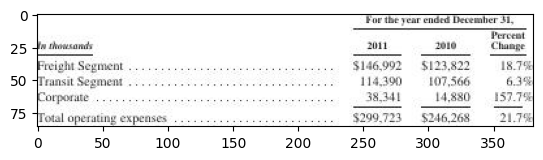

In [ ]:
plt.imshow(image)

 shape of original image (86, 381, 3)


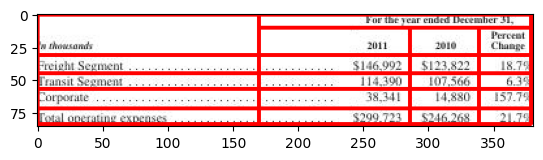

In [ ]:
threshold = 0.1
imgae_split_input = np.array(image)
image_test = imgae_split_input.copy()
imgae_split_input_512 = cv2.resize(imgae_split_input, (SHAPE, SHAPE))
image_input = imgae_split_input_512.astype('float')
image_input = np.array(image_input,dtype= np.float32)/255.0
image_tensor =  torch.from_numpy(image_input)
image_tensor = image_tensor.permute(2,0,1)
image_tensor = torch.unsqueeze(image_tensor, dim = 0)
h_original , w_original =  image_test.shape[0], image_test.shape[1]               # image_test.height, image_test.width
print(f' shape of original image {np.array(image_test).shape}')
threshold_contour_col = 5
if h_original < 100:
    threshold_contour_row = 5
else :
    threshold_contour_row = 1
a,b = split_task(image_tensor)
row_list_ = get_row_pred_line(a)
# row_list_ = sorted(row_list_)
col_list_ = get_col_pred_line(b)
# col_list_ = sorted(col_list_)
# show_line_pred(row_list_, col_list_, imgae_split_input_512)
row_list_ = sorted(row_list_)
row_list_ = [x if x > 15 else 0 for x in row_list_]
col_list_ = sorted(col_list_)
col_list_ = [x if x > 5 else 0 for x in col_list_]
cell_bbox_ = get_pred_bbox_list(row_list_ , col_list_)
bbox_input =  torch.from_numpy(np.array([cell_bbox_]))
row_pred, col_pred = merge_task(image_tensor, bbox_input)
last_cell = bbox_input.numpy()[-1]
num_row, num_col =  last_cell[-1][0] , last_cell[-1][1]
row_merge , col_merge  = get_final_pred_merge(row_pred, col_pred, num_row, num_col)
table_dict  = get_table(row_merge, col_merge, np.array(cell_bbox_) )
show_final_result_v2(imgae_split_input , table_dict)

In [ ]:
col_merge

array([[0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

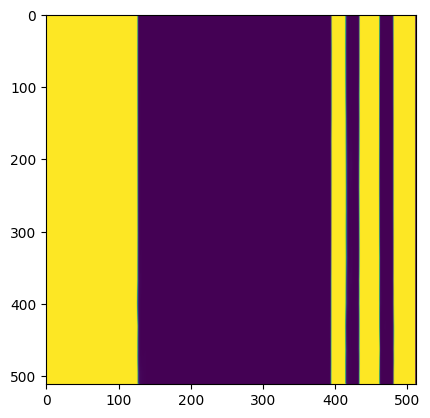

In [ ]:
c  = get_heatmap_split(b)

In [ ]:
row_merge

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
html_pred = generate_html_table(table_dict)

In [ ]:
html_code  = "<html><body>" + html_code + "</body></html>"

In [ ]:
html_pred = "<html><body>" + html_pred + "</body></html>"

In [ ]:
html_code.replace("table border='1'", "table")

"<html><body><table>\n  <tr>\n    <td rowspan='2'>In thousands</td>\n    <td colspan='3'>For the year ended December 31,</td>\n  </tr>\n  <tr>\n    <td>2011</td>\n    <td>2010</td>\n    <td>Percent Change</td>\n  </tr>\n  <tr>\n    <td>Freight Segment</td>\n    <td>$146,992</td>\n    <td>$123,822</td>\n    <td>18.7%</td>\n  </tr>\n  <tr>\n    <td>Transit Segment</td>\n    <td>114,390</td>\n    <td>107,566</td>\n    <td>6.3%</td>\n  </tr>\n  <tr>\n    <td>Corporate</td>\n    <td>38,341</td>\n    <td>14,880</td>\n    <td>157.7%</td>\n  </tr>\n  <tr>\n    <td>Total operating expenses</td>\n    <td>$299,723</td>\n    <td>$246,268</td>\n    <td>21.7%</td>\n  </tr>\n</table></body></html>"

In [ ]:
html_pred.replace("table border='1'", "table")

"<html><body><table>\n  <tr>\n    <td rowspan='2'></td>\n    <td colspan='3'></td>\n  </tr>\n  <tr>\n    <td></td>\n    <td></td>\n    <td></td>\n  </tr>\n  <tr>\n    <td></td>\n    <td></td>\n    <td></td>\n    <td></td>\n  </tr>\n  <tr>\n    <td></td>\n    <td></td>\n    <td></td>\n    <td></td>\n  </tr>\n  <tr>\n    <td></td>\n    <td></td>\n    <td></td>\n    <td></td>\n  </tr>\n  <tr>\n    <td></td>\n    <td></td>\n    <td></td>\n    <td></td>\n  </tr>\n</table></body></html>"

In [ ]:
# Initialize the TEDS metric with tree_weight=1.0 for structure-only comparison
teds = TEDS(tree_weight=1.0)

# Compute the TEDS score (structure only)
score = teds.compute_teds(html_pred, html_code)

print("TEDS Score (Structure Only):", score)

TypeError: TEDS.__init__() got an unexpected keyword argument 'tree_weight'

In [ ]:
from IPython.core.display import display, HTML
# html_code = generate_html_table(final_table_dict_2)
display(HTML(html_code))

In [ ]:
!pip install table_recognition_metric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.1 MB/s eta 0:00:00


In [ ]:
from table_recognition_metric import TEDS

teds = TEDS(structure_only=True)

In [ ]:
score = teds(html_code, html_pred)
print(score)

1.0


# apply easy ocr

In [ ]:
!pip install paddlepaddle
!pip install paddleocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 16.8 MB/s eta

In [ ]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
ocr = PaddleOCR(use_angle_cls=True, lang="en")

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:17<00:00, 222.98it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:17<00:00, 566.30it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:14<00:00, 144.07it/s]

[2025/02/09 07:06:17] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [ ]:
final_table_dict  = []

for cell in table_dict:
  cell_dict = dict()
  bbox = cell['bbox']
  x1_512 , y1_512 , x2_512, y2_512 = bbox
  x1_ori = int(x1_512/512 * w_original)
  y1_ori = int(y1_512/512 * h_original)
  x2_ori = int(x2_512/512 * w_original)
  y2_ori = int(y2_512/512 * h_original)
  row_cnt = cell['row']
  col_cnt = cell['col']
  content = ''
  cell_dict['row'] = row_cnt
  cell_dict['col'] = col_cnt
  cell_dict['bbox'] = [x1_ori, y1_ori, x2_ori, y2_ori]
  final_table_dict.append(cell_dict)


In [ ]:
table_image_original = imgae_split_input.copy()
# plt.imshow(table_image_original)
# plt.show()
final_table_dict_2 = []
for cell in final_table_dict:
  cell_dict = dict()
  bbox = cell['bbox']
  x1, y1, x2, y2 = bbox
  row_cnt = cell['row']
  col_cnt = cell['col']
  content = ''
  cell_dict['row'] = row_cnt
  cell_dict['col'] = col_cnt
  # print(f' num :{row_cnt},  {col_cnt}')
  # cell_dict['bbox'] = [x1, y1, x2, y2]
  sub_image = table_image_original[y1:y2, x1:x2]
  # plt.imshow(sub_image)
  # plt.show()
  scale_factor = 4  # Adjust as needed
  resized_image = cv2.resize(sub_image, (sub_image.shape[1] * scale_factor, sub_image.shape[0] * scale_factor), interpolation=cv2.INTER_CUBIC)

  result = ocr.ocr(resized_image, cls=True)
  # check if result not empty
  content = ''
  if not result[0]:
    cell_dict['content'] = content
    final_table_dict_2.append(cell_dict)
  else:
    for line in result[0]:
        # print(f'ocr : {line}')  # Extracted text
        # content_box = str(line[1][0])

        content  = content + ' ' + str(line[1][0])
        # for line in result[0]:
        # for text in line:
        #   print(f' text :{text}')
        #   content = content + ' ' + str(text[1][0])
        cell_dict['content'] = content
        final_table_dict_2.append(cell_dict)
        # cell_dict['content'] = content_box
        # final_table_dict_2.append(cell_dict)



[2025/02/09 07:54:18] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1510162353515625
[2025/02/09 07:54:18] ppocr DEBUG: cls num  : 1, elapsed : 0.019798755645751953
[2025/02/09 07:54:18] ppocr DEBUG: rec_res num  : 1, elapsed : 0.17590951919555664
[2025/02/09 07:54:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.1287856101989746
[2025/02/09 07:54:19] ppocr DEBUG: cls num  : 1, elapsed : 0.02045154571533203
[2025/02/09 07:54:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08262085914611816
[2025/02/09 07:54:19] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.13761639595031738
[2025/02/09 07:54:19] ppocr DEBUG: cls num  : 1, elapsed : 0.01938152313232422
[2025/02/09 07:54:19] ppocr DEBUG: rec_res num  : 1, elapsed : 0.2355647087097168
[2025/02/09 07:54:19] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.20932388305664062
[2025/02/09 07:54:19] ppocr DEBUG: cls num  : 0, elapsed : 0
[2025/02/09 07:54:19] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06
[2025/02/09 07:54:19] ppocr DEBUG: dt

In [ ]:
final_table_dict_2

[{'row': 0, 'col': [1, 2, 3], 'content': ' YearsEnded December 31,'},
 {'row': 2, 'col': [1, 2, 3], 'content': ' (In thousands)'},
 {'row': 4,
  'col': [0, 1, 2, 3],
  'content': ' Other comprehensive(loss)income'},
 {'row': [0, 2], 'col': 0, 'content': ''},
 {'row': [1], 'col': [0], 'content': ''},
 {'row': [1], 'col': [1], 'content': ' 2015'},
 {'row': [1], 'col': [2], 'content': ' 2014'},
 {'row': [1], 'col': [3], 'content': ' 2013'},
 {'row': [3], 'col': [0], 'content': ' Net income'},
 {'row': [3], 'col': [1], 'content': ' $605,428'},
 {'row': [3], 'col': [2], 'content': ' $516,140'},
 {'row': [3], 'col': [3], 'content': ' $496.170'},
 {'row': [5], 'col': [0], 'content': ' Unrealized loss available-for-sale'},
 {'row': [5], 'col': [0], 'content': ' Unrealized loss available-for-sale'},
 {'row': [5], 'col': [1], 'content': ' (2.870)'},
 {'row': [5], 'col': [2], 'content': ' (264)'},
 {'row': [5], 'col': [3], 'content': ' (7.592)'},
 {'row': [6], 'col': [0], 'content': ' Tax benefit

In [ ]:
from IPython.core.display import display, HTML
html_code = generate_html_table(final_table_dict_2)
display(HTML(html_code))

# using excel

In [ ]:
final_table_dict_2

[{'row': 0, 'col': [1, 2, 3], 'content': ' YearsEnded December 31,'},
 {'row': 2, 'col': [1, 2, 3], 'content': ' (In thousands)'},
 {'row': 4,
  'col': [0, 1, 2, 3],
  'content': ' Other comprehensive(loss)income'},
 {'row': [0, 2], 'col': 0, 'content': ''},
 {'row': [1], 'col': [0], 'content': ''},
 {'row': [1], 'col': [1], 'content': ' 2015'},
 {'row': [1], 'col': [2], 'content': ' 2014'},
 {'row': [1], 'col': [3], 'content': ' 2013'},
 {'row': [3], 'col': [0], 'content': ' Net income'},
 {'row': [3], 'col': [1], 'content': ' $605,428'},
 {'row': [3], 'col': [2], 'content': ' $516,140'},
 {'row': [3], 'col': [3], 'content': ' $496.170'},
 {'row': [5], 'col': [0], 'content': ' Unrealized loss available-for-sale'},
 {'row': [5], 'col': [0], 'content': ' Unrealized loss available-for-sale'},
 {'row': [5], 'col': [1], 'content': ' (2.870)'},
 {'row': [5], 'col': [2], 'content': ' (264)'},
 {'row': [5], 'col': [3], 'content': ' (7.592)'},
 {'row': [6], 'col': [0], 'content': ' Tax benefit

In [ ]:
def is_integer(var):
  return isinstance(var, int)

In [ ]:
import openpyxl
import pandas as pd
from openpyxl import load_workbook
row_merge.shape
row_max , col_max = row_merge.shape
print(f'row_max: {row_max} , col_max :{col_max}')
wb = openpyxl.Workbook()
sheet = wb.active
for data_cell in final_table_dict_2:
  row_cnt = data_cell['row']
  col_cnt = data_cell['col']
  try:
    start_row = int(data_cell['row']) + 1
  except:
    start_row = int(data_cell['row'][0]) + 1
  try:
    start_col = int(data_cell['col']) + 1
  except:
    start_col = int(data_cell['col'][0]) + 1
  content = data_cell['content']
  if not content:
    content = ' '
  sheet.cell(row=start_row, column=start_col, value=content)
for data_cell in final_table_dict_2:
  # check spanning cell
  row_merge_flag = 0
  col_merge_flag = 0
  row_cnt = data_cell['row']
  col_cnt = data_cell['col']
  # print(row_cnt)
  # print(col_cnt)
  if not is_integer(row_cnt):
    row_merge_flag = 1
  if not is_integer(col_cnt):
    col_merge_flag = 1
  if col_merge_flag == 1 and row_merge_flag == 0:
    start_col = int(data_cell['col'][0]) + 1
    end_col = int(data_cell['col'][-1]) + 1
    start_row = int(data_cell['row']) + 1
    end_row = int(data_cell['row']) + 1
    sheet.merge_cells(start_row=start_row, start_column=start_col, end_row=end_row, end_column=end_col)
  if col_merge_flag == 0 and row_merge_flag == 1:
    start_col = int(data_cell['col']) + 1
    end_col = int(data_cell['col']) + 1
    start_row = int(data_cell['row'][0]) + 1
    end_row = int(data_cell['row'][-1]) + 1
    sheet.merge_cells(start_row=start_row, start_column=start_col, end_row=end_row, end_column=end_col)
  if col_merge_flag == 1 and row_merge_flag == 1:
    start_col = int(data_cell['col'][0]) + 1
    end_col = int(data_cell['col'][-1]) + 1
    start_row = int(data_cell['row'][0]) + 1
    end_row = int(data_cell['row'][-1]) + 1
    sheet.merge_cells(start_row=start_row, start_column=start_col, end_row=end_row, end_column=end_col)
wb.save('test.xlsx')

row_max: 16 , col_max :4


In [ ]:
def excel_to_html(excel_path, sheet_name=0):
    wb = load_workbook(excel_path)
    ws = wb[wb.sheetnames[sheet_name]] if isinstance(sheet_name, int) else wb[sheet_name]

    merged_cells = ws.merged_cells.ranges  # Get merged cell ranges
    df = pd.read_excel(excel_path, sheet_name=sheet_name, dtype=str)

    html = '<table border="1">\n'
    for i, row in enumerate(ws.iter_rows(values_only=True)):
        html += "  <tr>\n"
        for j, cell in enumerate(row):
            rowspan, colspan = 1, 1
            for merged in merged_cells:
                if ws.cell(row=i+1, column=j+1).coordinate in merged:
                    rowspan = merged.size["rows"]
                    colspan = merged.size["columns"]
                    if i+1 != merged.min_row or j+1 != merged.min_col:
                        cell = None  # Skip duplicate merged cells

            if cell is not None:
                attributes = ""
                if rowspan > 1:
                    attributes += f' rowspan="{rowspan}"'
                if colspan > 1:
                    attributes += f' colspan="{colspan}"'
                html += f'    <td{attributes}>{cell}</td>\n'

        html += "  </tr>\n"
    html += "</table>"

    return html

In [ ]:
def workbook_to_html(wb, sheet_name=0):
    ws = wb[wb.sheetnames[sheet_name]] if isinstance(sheet_name, int) else wb[sheet_name]
    merged_cells = ws.merged_cells.ranges  # Get merged cell ranges

    html = '<table border="1">\n'
    for i, row in enumerate(ws.iter_rows(values_only=True)):
        html += "  <tr>\n"
        for j, cell in enumerate(row):
            rowspan, colspan = 1, 1
            for merged in merged_cells:
                if ws.cell(row=i+1, column=j+1).coordinate in merged:
                    rowspan = merged.size["rows"]
                    colspan = merged.size["columns"]
                    if i+1 != merged.min_row or j+1 != merged.min_col:
                        cell = None  # Skip duplicate merged cells

            if cell is not None:
                attributes = ""
                if rowspan > 1:
                    attributes += f' rowspan="{rowspan}"'
                if colspan > 1:
                    attributes += f' colspan="{colspan}"'
                html += f'    <td{attributes}>{cell}</td>\n'

        html += "  </tr>\n"
    html += "</table>"

    return html

In [ ]:
html_test = workbook_to_html(wb)
display(HTML(html_test))

In [ ]:
html_test

'<table border="1">\n  <tr>\n    <td rowspan="3"> </td>\n    <td colspan="3"> YearsEnded December 31,</td>\n  </tr>\n  <tr>\n    <td> 2015</td>\n    <td> 2014</td>\n    <td> 2013</td>\n  </tr>\n  <tr>\n    <td colspan="3"> (In thousands)</td>\n  </tr>\n  <tr>\n    <td> Net income</td>\n    <td> $605,428</td>\n    <td> $516,140</td>\n    <td> $496.170</td>\n  </tr>\n  <tr>\n    <td colspan="4"> Other comprehensive(loss)income</td>\n  </tr>\n  <tr>\n    <td> Unrealized loss available-for-sale</td>\n    <td> (2.870)</td>\n    <td> (264)</td>\n    <td> (7.592)</td>\n  </tr>\n  <tr>\n    <td> Tax benefit (expense)</td>\n    <td> 149</td>\n    <td> (1,271)</td>\n    <td> 1,460</td>\n  </tr>\n  <tr>\n    <td> Unrealized loss on securities available-for-sale. net of tax</td>\n    <td> (2,721)</td>\n    <td> (1,535)</td>\n    <td> (6,132)</td>\n  </tr>\n  <tr>\n    <td> Unrealized dlos ash flow bede</td>\n    <td> (1.359)</td>\n    <td> 3,302</td>\n    <td> </td>\n  </tr>\n  <tr>\n    <td> Tax 

In [ ]:
# y1 = 50
# y2 = 65
# x1 = 287
# x2 = 365
# sub_image = table_image_original[y1:y2, x1:x2]
# plt.imshow(sub_image)

In [ ]:
# ocr_2 = PaddleOCR(det_db_box_thresh=0.1, use_angle_cls=True, lang="en")
# scale_factor = 4  # Adjust as needed
# resized_image = cv2.resize(sub_image, (sub_image.shape[1] * scale_factor, sub_image.shape[0] * scale_factor), interpolation=cv2.INTER_CUBIC)

# # Run OCR on the resized image
# results = ocr.ocr(resized_image, cls=True)
# results[0]

In [ ]:
# line = results[0]
# line[0][1]

In [ ]:
# white_image = np.ones_like(table_image_original) * 255
# white_image[y1:y2, x1:x2, :] = table_image_original[y1:y2, x1:x2,:]
# plt.imshow(white_image)

In [ ]:
# result = ocr_2.ocr(table_image_original, cls=True)
# result

In [ ]:
def generate_html_table(data: list) -> str:
    table = "<table border='1'>\n"

    # Find max row and col to determine table size
    max_row = max(
        max(item['row']) if isinstance(item['row'], list) else item['row']
        for item in data
    )
    max_col = max(
        max(item['col']) if isinstance(item['col'], list) else item['col']
        for item in data
    )

    # Create an empty table structure
    table_structure = [['' for _ in range(max_col + 1)] for _ in range(max_row + 1)]
    span_map = {}

    # Populate the table with data
    for item in data:
        try:
          rows = item['row'] if isinstance(item['row'], list) else [item['row']]
          cols = item['col'] if isinstance(item['col'], list) else [item['col']]
          content = item['content']

          span_map[(rows[0], cols[0])] = (len(rows), len(cols))
          table_structure[rows[0]][cols[0]] = content
        except:
          pass

        # Mark spanned cells
        for r in rows:
            for c in cols:
                if (r, c) != (rows[0], cols[0]):
                    table_structure[r][c] = None

    # Generate HTML table rows
    for r, row in enumerate(table_structure):
        table += "  <tr>\n"
        for c, cell in enumerate(row):
            if cell is not None:
                rowspan, colspan = span_map.get((r, c), (1, 1))
                rowspan_attr = f" rowspan='{rowspan}'" if rowspan > 1 else ""
                colspan_attr = f" colspan='{colspan}'" if colspan > 1 else ""
                table += f"    <td{rowspan_attr}{colspan_attr}>{cell}</td>\n"
        table += "  </tr>\n"

    table += "</table>"
    return table



# New Section

In [ ]:
html_code = generate_html_table(final_table_dict_2)
# print(html_code)

In [ ]:
final_table_dict_2

[{'row': 0, 'col': [1, 2, 3], 'content': ' Year Ended December 31'},
 {'row': [0, 1], 'col': 0, 'content': ' Millions of dollars'},
 {'row': [1], 'col': [1], 'content': ' 2014'},
 {'row': [1], 'col': [2], 'content': ' 2013'},
 {'row': [1], 'col': [3], 'content': ' 2012'},
 {'row': [2], 'col': [0], 'content': ' Stock-based compensation cost'},
 {'row': [2], 'col': [1], 'content': ' S 298'},
 {'row': [2], 'col': [1], 'content': ' S 298'},
 {'row': [2], 'col': [2], 'content': ' S 264'},
 {'row': [2], 'col': [2], 'content': ' S 264'},
 {'row': [2], 'col': [3], 'content': ' S 217'},
 {'row': [2], 'col': [3], 'content': ' S 217'},
 {'row': [3], 'col': [0], 'content': ' Tax benefit'},
 {'row': [3], 'col': [1], 'content': ' (90)'},
 {'row': [3], 'col': [2], 'content': ' (81)'},
 {'row': [3], 'col': [3], 'content': ' (67)'},
 {'row': [4],
  'col': [0],
  'content': ' Stock-based compensation cost, net of tax'},
 {'row': [4], 'col': [1], 'content': ' $ 208'},
 {'row': [4], 'col': [1], 'content':

In [ ]:
from IPython.core.display import display, HTML
html_code = generate_html_table(final_table_dict_2)
display(HTML(html_code))

In [ ]:
final_table_dict_2

In [ ]:
def generate_html_table(data_dict):
  html = '<table border="1" style="border-collapse: collapse;">\n'
  for row_idx in range(num_row):
      html += '  <tr>\n'
      for col_idx in range(num_col):
        row_members_list = []
        row_have_span_col_flag  = 0
        row_have_span_row_flag  = 0
        for cell_data in data_dict:
          if col_idx in cell_data['col'] and row_idx in cell_data['row']:
            row_members_list.append(cell_data['content'])
  html = html + '</table>'


In [ ]:
final_table_dict_2.get(5,2)

In [ ]:


html_output = generate_html_table(final_table_dict_2)
# print(html_output)
display(HTML(html_output))

In [ ]:
table_dict

# pytesseract

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
try:
 from PIL import Image
except ImportError:
 import Image
import cv2
import pytesseract


In [ ]:
!which tesseract

In [ ]:
final_table_dict  = []

for cell in table_dict:
  cell_dict = dict()
  bbox = cell['bbox']
  x1_512 , y1_512 , x2_512, y2_512 = bbox
  x1_ori = int(x1_512/512 * w_original)
  y1_ori = int(y1_512/512 * h_original)
  x2_ori = int(x2_512/512 * w_original)
  y2_ori = int(y2_512/512 * h_original)
  row_cnt = cell['row']
  col_cnt = cell['col']
  content = ''
  cell_dict['row'] = row_cnt
  cell_dict['col'] = col_cnt
  cell_dict['bbox'] = [x1_ori, y1_ori, x2_ori, y2_ori]
  final_table_dict.append(cell_dict)

In [ ]:
table_image_original = imgae_split_input.copy()
# plt.imshow(table_image_original)
# plt.show()
final_table_dict_2 = []
for cell in final_table_dict:
  cell_dict = dict()
  bbox = cell['bbox']
  x1, y1, x2, y2 = bbox
  row_cnt = cell['row']
  col_cnt = cell['col']
  content = ''
  cell_dict['row'] = row_cnt
  cell_dict['col'] = col_cnt
  # cell_dict['bbox'] = [x1, y1, x2, y2]
  sub_image = table_image_original[y1:y2, x1:x2]
  lang = 'eng'
  config = r'--oem 3 --psm 6'
  extractedInformation = pytesseract.image_to_string(sub_image, config = "--psm 6")
  content = extractedInformation
  # content = content.strip()
  cell_dict['content'] = content
  final_table_dict_2.append(cell_dict)


In [ ]:
final_table_dict_2

In [ ]:
final_table_dict
x1 , y1 , x2, y2 = 287, 20, 356, 35
sub_image = table_image_original[y1:y2, x1:x2]
plt.imshow(sub_image)

In [ ]:
def process_table_cell(cell_image):
    """Processes a single table cell image for OCR."""

    roi = cell_image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    border = cv2.copyMakeBorder(roi,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    dilation = cv2.dilate(resizing, kernel,iterations=1)
    erosion = cv2.erode(dilation, kernel,iterations=2)
    out = pytesseract.image_to_string(erosion)
    if(len(out)==0):
      out = pytesseract.image_to_string(erosion)
    # 3. Post-processing (basic)
    text = out.strip()  # Remove leading/trailing whitespace

    return text

In [ ]:
table_image_original = imgae_split_input.copy()
# plt.imshow(table_image_original)
# plt.show()
final_table_dict_2 = []
for cell in final_table_dict:
  cell_dict = dict()
  bbox = cell['bbox']
  x1, y1, x2, y2 = bbox
  row_cnt = cell['row']
  col_cnt = cell['col']
  content = ''
  cell_dict['row'] = row_cnt
  cell_dict['col'] = col_cnt
  # cell_dict['bbox'] = [x1, y1, x2, y2]
  sub_image = table_image_original[y1:y2, x1:x2]
  content = process_table_cell(sub_image)
  # content = content.strip()
  cell_dict['content'] = content
  final_table_dict_2.append(cell_dict)

In [ ]:
final_table_dict_2

In [ ]:
final_table_dict

In [ ]:
# pytesseract.image_to_string(sub_image, lang = lang, config = '--oem 1 --psm 7')
x1 , y1 , x2, y2 = 287, 0, 406, 20
sub_image = table_image_original[y1:y2, x1:x2]
white_image = np.ones_like(table_image_original) * 255
white_image[y1:y2, x1:x2, :] = table_image_original[y1:y2, x1:x2,:]
plt.imshow(white_image)
text = pytesseract.image_to_string(table_image_original,lang = lang, config = '--psm 6')
text

In [ ]:
plt.imshow(table_image_original)

In [ ]:
# roi = table_image_original[y1:y2, x1:x2]
roi = white_image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
border = cv2.copyMakeBorder(roi,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
dilation = cv2.dilate(resizing, kernel,iterations=1)
erosion = cv2.erode(dilation, kernel,iterations=2)
out = pytesseract.image_to_string(erosion , config = '--psm 6')
if(len(out)==0):
  print('aaa')
  out = pytesseract.image_to_string(erosion)


In [ ]:
plt.imshow(erosion)

In [ ]:
out